# Sinusoidal model
In a first step the different blood flow models are tested with the given sinusoidal tissue architecture. The blood flow model is either 
* constant flow, i.e. identical flow in all areas of the sinusoid
* pressure dependent capillary model, i.e. different regional flow with flow component orthogonal to sinusoid direction

In [1]:
%matplotlib inline
from __future__ import print_function, division
import tellurium as te
from matplotlib import pyplot as plt
import clearance
import os
from multiscale.simulate import roadrunner_tools as rt

Time<__init__> SBML compile: 0.652238130569 [s]
Time<simulate> : 0.00303292274475 [s]


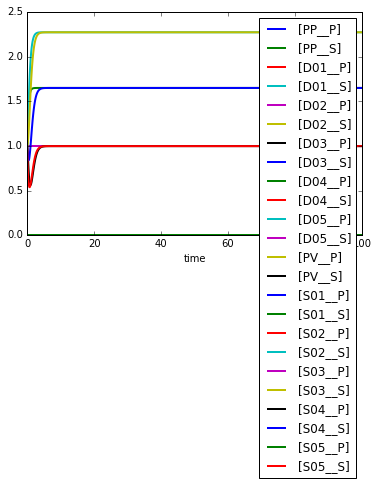

In [2]:
# flow model
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc5_v3.xml')
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc20_v3.xml')
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_flow_Nc100_v3.xml')

# pressure model
sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc5_v3.xml')
sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc5_v3-diffusion.xml')
sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc5_v3-xflow.xml')
sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc5_v3-only-xflow.xml')
# sbml_path = os.path.join(clearance.target_dir, 'sinusoidal_pressure_Nc20_v3.xml')

r = rt.MyRunner(sbml_path)
r.integrator.absolute_tolerance = 1E-20
r.integrator.variable_step_size = True
# make selections
r.select_concentrations()
# simple simulation
r.resetToOrigin()
s = r.simulate(0,100)
r.plot(s);

(0, 5)

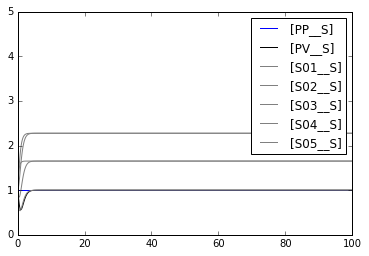

In [3]:
plt.plot(s['time'], s['[PP__S]'], color='blue', label='[PP__S]')
plt.plot(s['time'], s['[PV__S]'], color='black', label='[PV__S]')
for k in range(int(r.Nc)):
    label = '[S{:02}__S]'.format(k+1)
    plt.plot(s['time'], s[label], color='gray', label=label)
plt.legend()
plt.ylim([0,5])

## Velocity of transportation
How fast is a change in concentration transported from periportal to perivenous.

Time<simulate> : 0.00362682342529 [s]


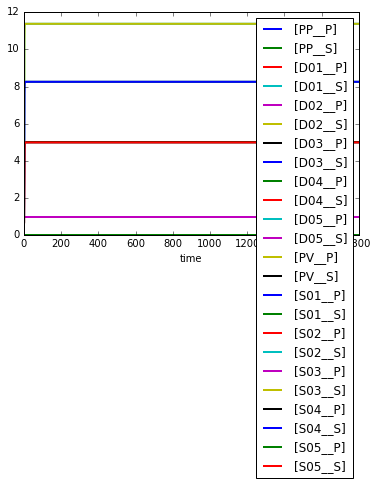

In [4]:
# perform periportal change
r.resetToOrigin()
r['[PP__S]'] = 5

s = r.simulate(0,1800)
r.plot(s);

In [5]:
import numpy as np
from multiscale.analysis import id_tools
reload(id_tools)
resolver = id_tools.IdResolver(selections=r.timeCourseSelections, Nc=r['Nc'])

sin_ids = resolver.sinusoidal_ids('S')
disse_ids = resolver.disse_ids('S')
pp_id = resolver.pp_id('S')
pv_id = resolver.pv_id('S')

print(resolver.find_indices(sin_ids))
print(resolver.find_indices(disse_ids))
print(resolver.find_indices([pp_id] + sin_ids + [pv_id]))
print(r.timeCourseSelections)

[16, 18, 20, 22, 24]
[4, 6, 8, 10, 12]
[2, 16, 18, 20, 22, 24, 14]
['time', '[PP__P]', '[PP__S]', '[D01__P]', '[D01__S]', '[D02__P]', '[D02__S]', '[D03__P]', '[D03__S]', '[D04__P]', '[D04__S]', '[D05__P]', '[D05__S]', '[PV__P]', '[PV__S]', '[S01__P]', '[S01__S]', '[S02__P]', '[S02__S]', '[S03__P]', '[S03__S]', '[S04__P]', '[S04__S]', '[S05__P]', '[S05__S]']


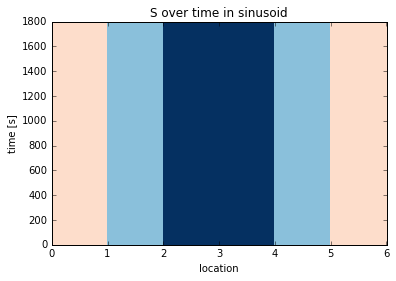

In [6]:
ids = [pp_id] + sin_ids + [pv_id]
indices = resolver.find_indices(ids)
s[:, indices]

plt.pcolor(range(0, int(r['Nc']+2)),s['time'], s[:, indices], cmap='RdBu')
plt.xlabel('location')
plt.ylabel('time [s]')
plt.title('S over time in sinusoid');

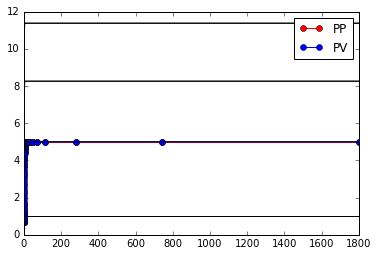

In [7]:
plt.plot(s['time'], s[pp_id], '-o', color='red', label='PP')
plt.plot(s['time'], s[pv_id], '-o', color='blue', label='PV')
plt.plot(s['time'], s[:, resolver.find_indices(sin_ids)], '-', color='black')
plt.plot(s['time'], s[:, resolver.find_indices(disse_ids)], '-', color='black')
plt.legend();

## Product formation
In the current state there is no metababolic model included.
For the transformation to P metabolic clearance is required within the cells.

['[S01__P]', '[S02__P]', '[S03__P]', '[S04__P]', '[S05__P]']
['[D01__P]', '[D02__P]', '[D03__P]', '[D04__P]', '[D05__P]']
[PP__P]
[PV__P]


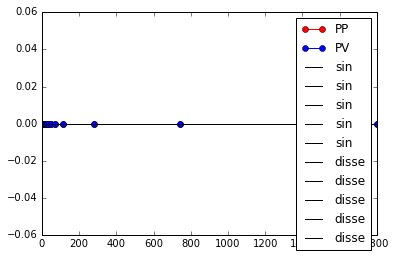

In [8]:
sin_ids_P = resolver.sinusoidal_ids('P')
disse_ids_P = resolver.disse_ids('P')
pp_id_P = resolver.pp_id('P')
pv_id_P = resolver.pv_id('P')
print(sin_ids_P)
print(disse_ids_P)
print(pp_id_P)
print(pv_id_P)


plt.plot(s['time'], s[pp_id_P], '-o', color='red', label='PP')
plt.plot(s['time'], s[pv_id_P], '-o', color='blue', label='PV')
plt.plot(s['time'], s[:, resolver.find_indices(sin_ids_P)], '-', color='black', label='sin')
plt.plot(s['time'], s[:, resolver.find_indices(disse_ids_P)], '-', color='black', label='disse')
plt.legend();

In [9]:

print(r['flow_sin'])
print(r['L'])

0.000478142265664
0.0005


In [10]:
Qin2 = r['S01S02_Q']
Qout2 = r['S02S03_Q']
print(Qin2/Qout2)

1.37754357495


In [11]:
reload(id_tools)
reload(rt)
gp = r.df_global_parameters()
df_P = id_tools.get_P(gp)
print(df_P)

        P        x
PP_x  NaN  0.00000
S01_x NaN  0.00005
S02_x NaN  0.00015
S03_x NaN  0.00025
S04_x NaN  0.00035
S05_x NaN  0.00045
PV_x  NaN  0.00050
